# Objetivos e Índice

#### Objetivos

Neste notebook a ideia principal é explorar/modelar as bases de trabalho

#### Índice

- 0.Imports: há a importação das libs e bases

- 1.Análise descritiva: buscando algumas informações descritivas das bases

# 0.Imports

#### 1. Importando as libs

In [48]:
# Importanto Libs e ferramentas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor
import joblib
from sklearn.model_selection import GridSearchCV

from sklearn.utils import Bunch
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

#### 2. Importando as bases

In [25]:
# Importando a base de conexões
csv_con_path = "../aux/conexoes_espec.csv"
df_con = pd.read_csv(csv_con_path, sep=';')

# Head
display(df_con.head())

,V1,V2,grau,proximidade,prob_V1_V2
0,1,2,trabalho,visita_frequente,0.589462
1,1,3,trabalho,visita_rara,0.708465
2,2,4,trabalho,visita_casual,NaN
3,2,5,trabalho,visita_rara,0.638842
4,3,6,amigos,mora_junto,NaN


In [26]:
# Importando a base de indivíduos
csv_ind_path = "../aux/individuos_espec.csv"
df_ind = pd.read_csv(csv_ind_path, sep=';')

# Head
display(df_ind.head())

,name,idade,estado_civil,qt_filhos,estuda,trabalha,pratica_esportes,transporte_mais_utilizado,IMC
0,1,44.0,divorciado,1.0,1.0,0.0,1.0,publico,22.200956
1,2,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720
2,3,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393
3,4,50.0,casado,1.0,1.0,1.0,0.0,publico,26.732053
4,5,30.0,solteiro,2.0,1.0,0.0,1.0,publico,15.295668


# 1.Análise Descritiva

Tópico para estudo dos dados da base e exploração visual inicial

## 1.1 Indivíduos

Primeiramente, estudando a base de indivíduos

In [4]:
# Contagem de linhas

len(df_ind)

1000000

In [5]:
# Verificando os tipos de dados

df_ind.dtypes

name                           int64
idade                        float64
estado_civil                  object
qt_filhos                    float64
estuda                       float64
trabalha                     float64
pratica_esportes             float64
transporte_mais_utilizado     object
IMC                          float64
dtype: object

In [6]:
# Verificando valores nulos

display(df_ind.isnull().sum())

name                              0
idade                         95937
estado_civil                  50073
qt_filhos                     28867
estuda                        40130
trabalha                       6353
pratica_esportes             149124
transporte_mais_utilizado     43033
IMC                          113870
dtype: int64

In [7]:
# Análise descritiva das variáveis numéricas

display(df_ind.describe())

,name,idade,qt_filhos,estuda,trabalha,pratica_esportes,IMC
count,1000000.000000,904063.000000,971133.000000,959870.000000,993647.000000,850876.000000,886130.000000
mean,500000.500000,30.008431,0.928406,0.442588,0.556739,0.599823,22.472079
std,288675.278932,10.951566,0.997289,0.496693,0.496771,0.489934,7.073692
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.852828
25%,250000.750000,22.000000,0.000000,0.000000,0.000000,0.000000,17.420851
50%,500000.500000,29.000000,1.000000,0.000000,1.000000,1.000000,21.431200
75%,750000.250000,37.000000,1.000000,1.000000,1.000000,1.000000,26.378197
max,1000000.000000,124.000000,9.000000,1.000000,1.000000,1.000000,89.158204


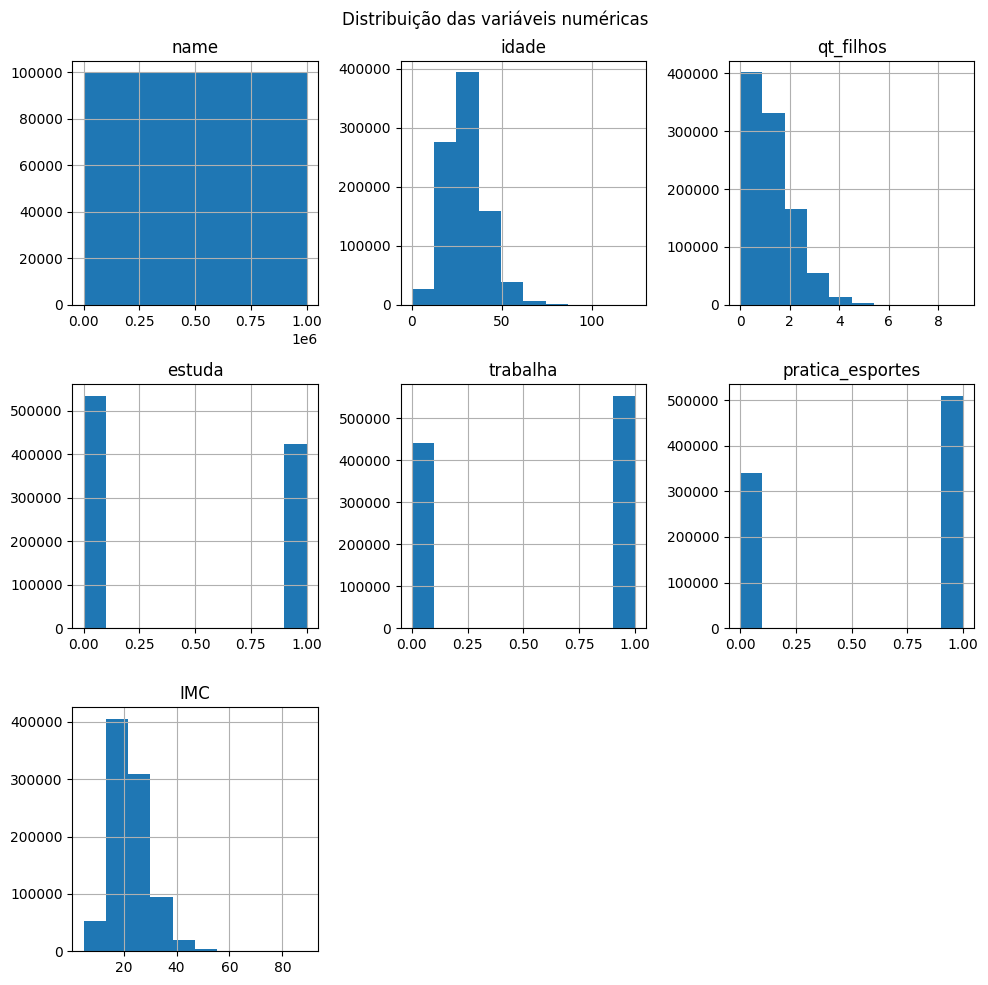

In [8]:
# Explorando as distribuições

df_ind.hist(figsize=(10, 10))
plt.suptitle('Distribuição das variáveis numéricas')
plt.tight_layout()
plt.show()

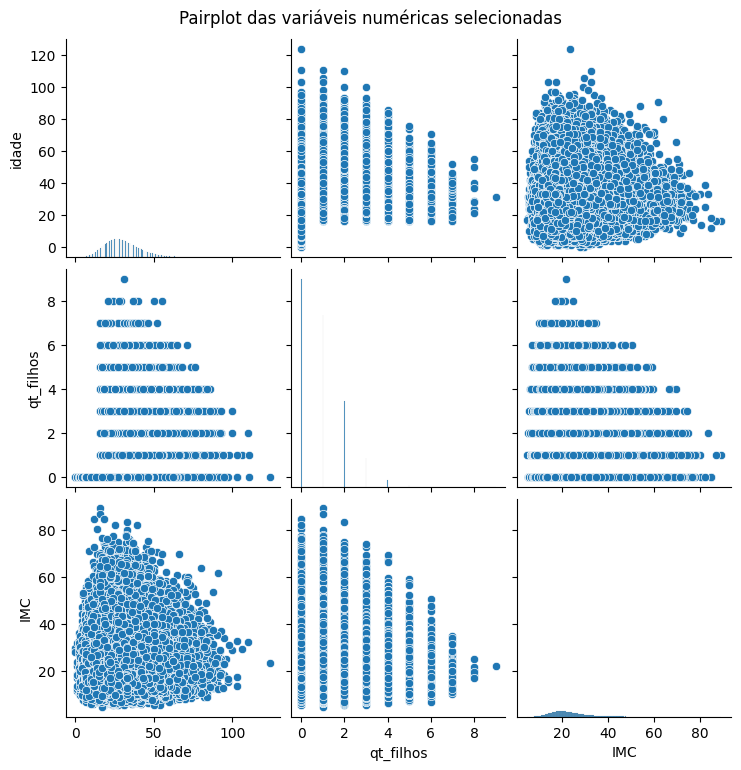

In [9]:
sns.pairplot(df_ind[['idade', 'qt_filhos', 'IMC']])
plt.suptitle('Pairplot das variáveis numéricas selecionadas', y=1.02)
plt.show()

In [10]:
# Variáveis categóricas

display(df_ind.describe(include='object'))

,estado_civil,transporte_mais_utilizado
count,949927,956967
unique,4,3
top,solteiro,publico
freq,420637,574779


## 1.2 Conexões

Estudando agora a base de conexões

In [11]:
# Contagem de linhas

len(df_con)

999999

In [12]:
# Verificando os tipos de dados

df_con.dtypes

V1               int64
V2               int64
grau            object
proximidade     object
prob_V1_V2     float64
dtype: object

In [13]:
# Verificando valores nulos

display(df_con.isnull().sum())

V1                  0
V2                  0
grau                0
proximidade         0
prob_V1_V2     500000
dtype: int64

In [14]:
# Análise descritiva das variáveis numéricas

display(df_con['prob_V1_V2'].describe())

count    499999.000000
mean          0.485162
std           0.173963
min           0.074462
25%           0.351677
50%           0.486413
75%           0.618210
max           0.942245
Name: prob_V1_V2, dtype: float64

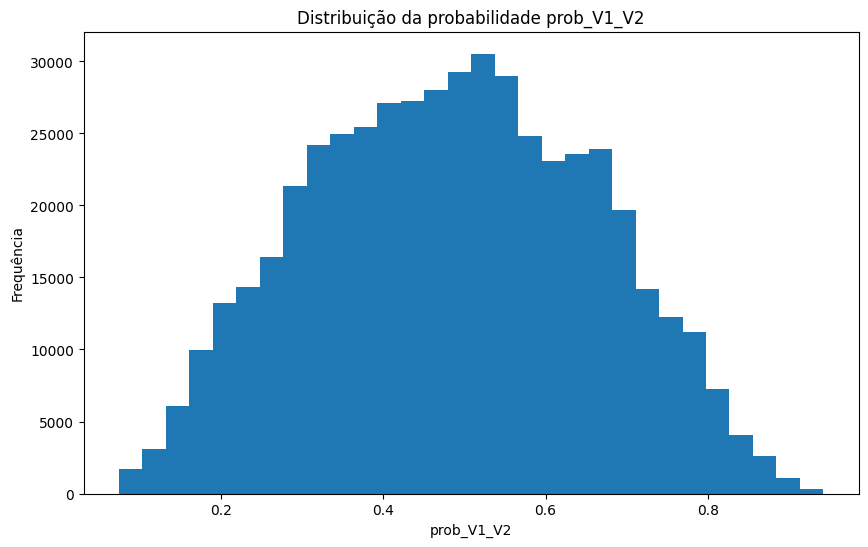

In [15]:
# Explorando as distribuições

df_con['prob_V1_V2'].plot(kind='hist', figsize=(10, 6), bins=30, title='Distribuição da probabilidade prob_V1_V2')
plt.xlabel('prob_V1_V2')
plt.ylabel('Frequência')
plt.show()

In [16]:
# Variáveis categóricas

display(df_con.describe(include='object'))

,grau,proximidade
count,999999,999999
unique,3,4
top,trabalho,visita_rara
freq,333548,400238


# 2.Modelagem

## 2.1 Preprocessando a tabela para a modelagem

Aqui experimentarei uma modelagem considerando as features de cada uns dos indivíduos.

In [38]:
# Renomeando colunas para o merge
df_ind_v1 = df_ind.rename(columns=lambda x: f"{x}_V1" if x != 'name' else 'V1')
df_ind_v2 = df_ind.rename(columns=lambda x: f"{x}_V2" if x != 'name' else 'V2')

# Merge dos dados com as conexões
df_merged = df_con.merge(df_ind_v1, on='V1', how='left')
df_merged = df_merged.merge(df_ind_v2, on='V2', how='left')

# Remover registros sem target (probabilidade)
df_model = df_merged[df_merged['prob_V1_V2'].notna()].copy()

display(df_model.head())

,V1,V2,grau,proximidade,prob_V1_V2,idade_V1,estado_civil_V1,qt_filhos_V1,estuda_V1,trabalha_V1,...,transporte_mais_utilizado_V1,IMC_V1,idade_V2,estado_civil_V2,qt_filhos_V2,estuda_V2,trabalha_V2,pratica_esportes_V2,transporte_mais_utilizado_V2,IMC_V2
0,1,2,trabalho,visita_frequente,0.589462,44.0,divorciado,1.0,1.0,0.0,...,publico,22.200956,24.0,casado,0.0,0.0,0.0,1.0,publico,25.378720
1,1,3,trabalho,visita_rara,0.708465,44.0,divorciado,1.0,1.0,0.0,...,publico,22.200956,35.0,solteiro,1.0,0.0,0.0,1.0,particular,19.952393
3,2,5,trabalho,visita_rara,0.638842,24.0,casado,0.0,0.0,0.0,...,publico,25.378720,30.0,solteiro,2.0,1.0,0.0,1.0,publico,15.295668
5,3,7,familia,visita_casual,0.709608,35.0,solteiro,1.0,0.0,0.0,...,particular,19.952393,55.0,solteiro,1.0,1.0,1.0,1.0,particular,NaN
7,4,9,amigos,visita_casual,0.465209,50.0,casado,1.0,1.0,1.0,...,publico,26.732053,42.0,divorciado,1.0,0.0,1.0,NaN,publico,40.793339


## 2.2 Loop para teste de vários modelos

In [55]:
# Separar as features e o target
X_raw = df_model.drop(columns=['prob_V1_V2'])
y = df_model['prob_V1_V2']

# One-hot encoding
X_encoded = pd.get_dummies(X_raw, drop_first=True)

# Separar em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Imputar valores numéricos ausentes
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)


# Lista de modelos a testar
models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42)
}

# Loop para treinar e avaliar cada modelo
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{name}: RMSE = {rmse:.4f}")


Linear Regression: RMSE = 0.1157
Ridge: RMSE = 0.1157
Lasso: RMSE = 0.1738
Decision Tree: RMSE = 0.0789
Random Forest: RMSE = 0.0572
Gradient Boosting: RMSE = 0.0682
XGBoost: RMSE = 0.0551


## 2.3 Otimizando o modelo XGBoost

In [56]:
# --- Carregamento dos dados ---
df_model = df_merged[df_merged['prob_V1_V2'].notna()].copy()

FEATURES = ['V1', 'V2', 'grau', 'proximidade', 'idade_V1', 'estado_civil_V1', 'qt_filhos_V1', 'estuda_V1', 
            'trabalha_V1', 'pratica_esportes_V1', 'transporte_mais_utilizado_V1', 'IMC_V1', 
            'idade_V2', 'estado_civil_V2', 'qt_filhos_V2', 'estuda_V2', 'trabalha_V2', 
            'pratica_esportes_V2', 'transporte_mais_utilizado_V2', 'IMC_V2']

X = df_model[FEATURES]
y = df_model['prob_V1_V2']

boolean_cols = ['estuda_V1', 'trabalha_V1', 'pratica_esportes_V1',
                'estuda_V2', 'trabalha_V2', 'pratica_esportes_V2']

categorical_cols = [
    'grau',
    'proximidade',
    'estado_civil_V1',
    'transporte_mais_utilizado_V1',
    'estado_civil_V2',
    'transporte_mais_utilizado_V2'
]

numerical_cols = list(set(FEATURES) - set(categorical_cols) - set(boolean_cols))

# --- Pré-processamento ---
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

bool_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('bool', bool_pipeline, boolean_cols),
    ('cat', cat_pipeline, categorical_cols)
])

# --- Pipeline completo com o modelo base ---
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(random_state=42))
])

# --- Separar treino/teste ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Parâmetros para grid search ---
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# --- Treinar com busca em grade ---
grid_search.fit(X_train, y_train)

print(f"Melhores parâmetros: {grid_search.best_params_}")
print(f"Melhor RMSE (validação cruzada): {-grid_search.best_score_:.4f}")

# --- Testar no conjunto de teste final ---
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE no teste final: {rmse_test:.4f}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits


Python(32212) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32213) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32214) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32215) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32216) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32217) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32218) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32219) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32220) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(32221) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Melhores parâmetros: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 200, 'model__subsample': 1.0}
Melhor RMSE (validação cruzada): 0.0504
RMSE no teste final: 0.0503


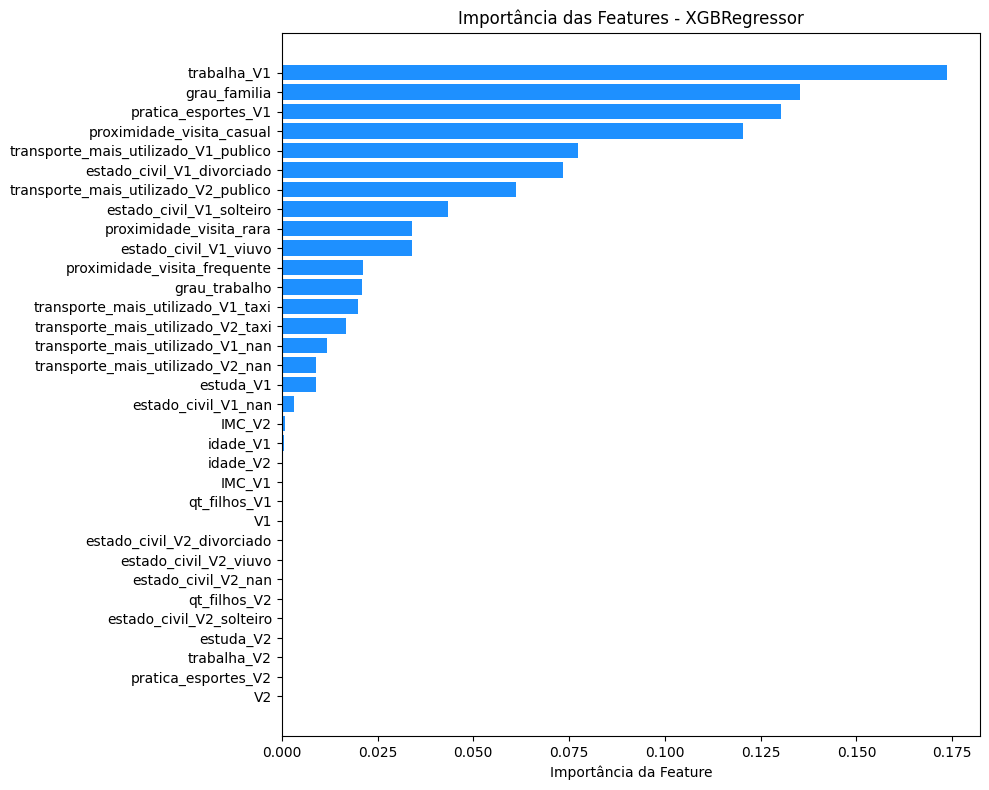

In [58]:
# Extrair o pré-processador do pipeline
preprocessor = best_model.named_steps['preprocessor']

# Obter as colunas numéricas e booleanas
num_cols = numerical_cols
bool_cols = boolean_cols

# Obter os nomes das colunas criadas pelo one-hot encoder para colunas categóricas
cat_transformer = preprocessor.named_transformers_['cat']
onehot = cat_transformer.named_steps['onehot']
cat_cols = onehot.get_feature_names_out(categorical_cols)

# Concatenar todos os nomes das features após o pré-processamento
feature_names = np.concatenate([num_cols, bool_cols, cat_cols])

# Extrair o modelo XGBRegressor treinado
model = best_model.named_steps['model']

# Obter a importância das features
importances = model.feature_importances_

# Criar dataframe para facilitar o plot
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=True)  # ordena para melhor visualização no gráfico

# Plotar o gráfico
plt.figure(figsize=(10, 8))
plt.barh(feat_imp_df['feature'], feat_imp_df['importance'], color='dodgerblue')
plt.xlabel('Importância da Feature')
plt.title('Importância das Features - XGBRegressor')
plt.tight_layout()
plt.show()


# 3. Salvando o modelo final

In [59]:
# --- Separar features e target ---
FEATURES = ['V1', 'V2', 'grau', 'proximidade', 'idade_V1', 'estado_civil_V1', 'qt_filhos_V1', 'estuda_V1', 
            'trabalha_V1', 'pratica_esportes_V1', 'transporte_mais_utilizado_V1', 'IMC_V1', 
            'idade_V2', 'estado_civil_V2', 'qt_filhos_V2', 'estuda_V2', 'trabalha_V2', 
            'pratica_esportes_V2', 'transporte_mais_utilizado_V2', 'IMC_V2']

X = df_model[FEATURES]
y = df_model['prob_V1_V2']

# --- Definir tipos de colunas ---
boolean_cols = ['estuda_V1', 'trabalha_V1', 'pratica_esportes_V1',
                'estuda_V2', 'trabalha_V2', 'pratica_esportes_V2']

categorical_cols = [
    'grau',
    'proximidade',
    'estado_civil_V1',
    'transporte_mais_utilizado_V1',
    'estado_civil_V2',
    'transporte_mais_utilizado_V2'
]

numerical_cols = list(set(FEATURES) - set(categorical_cols) - set(boolean_cols))

# --- Pré-processamento ---
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

bool_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_cols),
    ('bool', bool_pipeline, boolean_cols),
    ('cat', cat_pipeline, categorical_cols)
])

# --- Modelo com hiperparâmetros otimizados ---
model = XGBRegressor(
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    subsample=1.0,
    colsample_bytree=0.8,
    random_state=42
)

# --- Pipeline completo ---
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

# --- Separar treino/teste ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Treinar ---
pipeline.fit(X_train, y_train)

# --- Avaliação ---
y_pred = pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE no teste final: {rmse:.4f}")  # Esperado: ~0.0547

# --- Salvar modelo final ---
joblib.dump(pipeline, '../modelo/xgb_pipeline.pkl')


RMSE no teste final: 0.0506


['../modelo/xgb_pipeline.pkl']

In [60]:
print(X.columns.tolist())

['V1', 'V2', 'grau', 'proximidade', 'idade_V1', 'estado_civil_V1', 'qt_filhos_V1', 'estuda_V1', 'trabalha_V1', 'pratica_esportes_V1', 'transporte_mais_utilizado_V1', 'IMC_V1', 'idade_V2', 'estado_civil_V2', 'qt_filhos_V2', 'estuda_V2', 'trabalha_V2', 'pratica_esportes_V2', 'transporte_mais_utilizado_V2', 'IMC_V2']
